## Dog Breed Classification

In this project we will use traditional CNN, CNN with data augmentation and finally transfer Learning by VGG16 model with weights pre-trained on Imagenet to solve the dog breed classification problem

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 2.x selected.
2.1.0


### Load Dataset Files

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
from PIL import Image
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob
import cv2
import scipy.misc
from skimage import transform
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from skimage.transform import resize
from keras.models import Model

import warnings
warnings.filterwarnings("ignore")


batch_size =128
epochs = 10

Using TensorFlow backend.


Now, upload the given dataset file shared with you in your google drive and give its path for the below given `project_path` variable. For example, a path is given below according to the file path in our google drive. You need to change this to match the path of yours.

In [0]:
project_path = "/content/drive/My Drive/DogBreed_Classification/"

Run the below code to extract all the images in the train.zip files given in the dataset. We are going to use these images as train and validation sets and their labels in further steps.

In [0]:
from zipfile import ZipFile
with ZipFile(project_path+'train.zip', 'r') as z:
  z.extractall()

Repeat the same step for test.zip

In [0]:
from zipfile import ZipFile
with ZipFile(project_path+'test.zip', 'r') as z:
  z.extractall()

Repeat the same step for sample_submission.csv.zip

In [0]:
from zipfile import ZipFile
with ZipFile(project_path+'sample_submission.csv.zip', 'r') as z:
  z.extractall()

Repeat the same step for labels.csv.zip

In [0]:
from zipfile import ZipFile
with ZipFile(project_path+'labels.csv.zip', 'r') as z:
  z.extractall()

After this process, we will have 4 files - Train folder, test folder and labels.csv and sample_submission.csv as part of your google drive

### Read labels.csv file using pandas

In [9]:
labels = pd.read_csv('labels.csv')
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [10]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
id       10222 non-null object
breed    10222 non-null object
dtypes: object(2)
memory usage: 159.8+ KB


### Print the count of each category of Dogs given in the dataset



In [11]:
labels['breed'].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

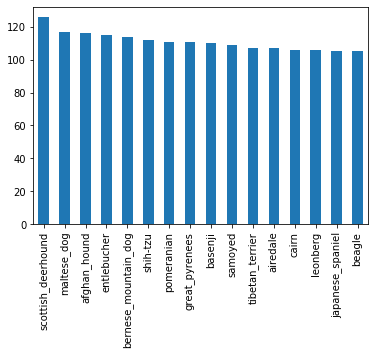

In [12]:
top_breeds = sorted(list(labels['breed'].value_counts().head(16).index))
labelstop = labels[labels['breed'].isin(top_breeds)]
labelstop.breed.value_counts().plot(kind='bar')

In [13]:
labels["breed"].unique()

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'borzoi', 'basenji', 'scottish_deerhound',
       'shetland_sheepdog', 'walker_hound', 'maltese_dog',
       'norfolk_terrier', 'african_hunting_dog',
       'wire-haired_fox_terrier', 'redbone', 'lakeland_terrier', 'boxer',
       'doberman', 'otterhound', 'standard_schnauzer',
       'irish_water_spaniel', 'black-and-tan_coonhound', 'cairn',
       'affenpinscher', 'labrador_retriever', 'ibizan_hound',
       'english_setter', 'weimaraner', 'giant_schnauzer', 'groenendael',
       'dhole', 'toy_poodle', 'border_terrier', 'tibetan_terrier',
       'norwegian_elkhound', 'shih-tzu', 'irish_terrier', 'kuvasz',
       'german_shepherd', 'greater_swiss_mountain_dog', 'basset',
       'australian_terrier', 'schipperke', 'rhodesian_ridgeback',
       'irish_setter', 'appenzeller', 'bloodhound', 'samoyed',
       'miniature_schnauzer', 'brittany_spaniel', 'kelpie', 'papillon',
       'borde

In [14]:
labels.breed.unique().size

120

### Get one-hot encodings of labels

In [0]:
targets_series = pd.Series(labels['breed'])
one_hot = pd.get_dummies(targets_series, sparse = True)
one_hot_labels = np.asarray(one_hot)

In [16]:
one_hot_labels[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

## Preparing training dataset
1. Write a code which reads each and every id from labels.csv file and loads the corresponding image (in RGB - 128, 128, 3) from the train folder. <br>
2. Create 2 variables <br> 
     a.  x_train - Should have all the images of the dogs from train folder <br>
     b.  y_train - Corresponding label of the dog <br>
<u>Note:</u> The id of the dog images and its corresponding labels are available in labels.csv file   
<u>Hint:</u> Watch the video shared on "Preparing the training dataset" if you face issue on creating the training dataset

In [17]:
img_rows = 128
img_cols = 128
x_train_data = []
y_train_data = []
i = 0 

for f, breed in tqdm(labels.values):
    img = cv2.imread('./train/{}.jpg'.format(f))
    label = one_hot_labels[i]
    x_train_data.append(cv2.resize(img, (img_rows, img_cols)))
    y_train_data.append(label)
    i += 1

100%|██████████| 10222/10222 [00:27<00:00, 368.48it/s]


**Using pickle for ease of access the next load**

In [0]:
import pickle

pickle_out = open("/content/drive/My Drive/Dog_breed_pickle/x_train_data.pickle","wb")
pickle.dump(x_train_data,pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/My Drive/Dog_breed_pickle/y_train_data.pickle","wb")
pickle.dump(y_train_data,pickle_out)
pickle_out.close()

**Reading x_train,y_train values from pickle file**

In [0]:
pickle_in = open("/content/drive/My Drive/Dog_breed_pickle/x_train_data.pickle","rb")
x_train_data = pickle.load(pickle_in) 
pickle_in.close()

pickle_in = open("/content/drive/My Drive/Dog_breed_pickle/y_train_data.pickle","rb")
y_train_data = pickle.load(pickle_in) 
pickle_in.close()

Normalize the training data and convert into 4 dimensions so that it can be used as an input to conv layers in the model

In [20]:
y_train_data_nor = np.array(y_train_data, np.uint8)
x_train_data_nor = np.array(x_train_data, np.float32) / 255.

num_class = y_train_data_nor.shape[1]

print(y_train_data_nor.shape)
print(x_train_data_nor.shape)

(10222, 120)
(10222, 128, 128, 3)


### Split the training and validation data from `x_train_data` and `y_train_data` obtained from above step

In [0]:
x_train_new, x_val, y_train_new, y_val = train_test_split(x_train_data_nor, y_train_data_nor, test_size=0.3, random_state=7)

### Loading the test data
Read the id column from the samples_submission.csv and store it in test_img

In [22]:
test_data= pd.read_csv('sample_submission.csv')
test_data.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333

In [23]:
test_img = test_data['id']
test_img

0        000621fb3cbb32d8935728e48679680e
1        00102ee9d8eb90812350685311fe5890
2        0012a730dfa437f5f3613fb75efcd4ce
3        001510bc8570bbeee98c8d80c8a95ec1
4        001a5f3114548acdefa3d4da05474c2e
                       ...               
10352    ffeda8623d4eee33c6d1156a2ecbfcf8
10353    fff1ec9e6e413275984966f745a313b0
10354    fff74b59b758bbbf13a5793182a9bbe4
10355    fff7d50d848e8014ac1e9172dc6762a3
10356    fffbff22c1f51e3dc80c4bf04089545b
Name: id, Length: 10357, dtype: object

Run the below code to load the test image files in x_test_feature

In [24]:
x_test_feature = []
i = 0 # initialisation
for f in tqdm(test_img.values): # f for format ,jpg
    img = cv2.imread('./test/{}.jpg'.format(f), 0)
    img_resize = cv2.resize(img, (img_rows, img_cols)) 
    x_test_feature.append(img_resize)

100%|██████████| 10357/10357 [00:14<00:00, 731.55it/s]


In [0]:
pickle_out = open("/content/drive/My Drive/Dog_breed_pickle/x_test_feature.pickle","wb")
pickle.dump(x_test_feature,pickle_out)
pickle_out.close()

pickle_in = open("/content/drive/My Drive/Dog_breed_pickle/x_test_feature.pickle","rb")
x_test_feature = pickle.load(pickle_in) 
pickle_in.close()

Normalize the test data and convert it into 4 dimensions

In [26]:
x_test_feature = np.array(x_test_feature, np.float32) / 255.
x_test_feature.shape

(10357, 128, 128)

In [27]:
num_breeds = y_train_new.shape[1]
num_breeds

120

### Build a basic conv neural network with 2 conv layers (kernel sizes - 5 and 3) add layers as mentioned below for classification.

1. Add a Dense layer with 256 neurons with `relu` activation

2. Add a Dense layer with 120 neurons as final layer (as there are 120 classes in the given dataset) with `softmax` activation for classifiaction. 

In [28]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(32, kernel_size=5, activation='relu',name='conv1',input_shape=(128,128,3)))
model.add(tf.keras.layers.Conv2D(32, kernel_size=3,name= 'conv2', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu',name= 'dense1'))
model.add(tf.keras.layers.Dense(120, activation='softmax',name= 'dense2'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 124, 124, 32)      2432      
_________________________________________________________________
conv2 (Conv2D)               (None, 122, 122, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 61, 61, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 119072)            0         
_________________________________________________________________
dense1 (Dense)               (None, 256)               30482688  
_________________________________________________________________
dense2 (Dense)               (None, 120)               30840     
Total params: 30,525,208
Trainable params: 30,525,208
Non-trainable params: 0
____________________________________________

In [0]:
adam = tf.keras.optimizers.Adam(lr=1e-6)

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=adam)

### Use batch_size = 128 and epochs = 10 and execute the model

In [30]:
model.fit(x_train_new, y_train_new ,validation_data=[x_val,y_val], epochs=epochs,batch_size=batch_size, verbose = 1)

Train on 7155 samples, validate on 3067 samples
Epoch 1/10
7155/7155 [==============================] - 11s 2ms/sample - loss: 4.7909 - accuracy: 0.0117 - val_loss: 4.7850 - val_accuracy: 0.0117
Epoch 2/10
7155/7155 [==============================] - 4s 556us/sample - loss: 4.7775 - accuracy: 0.0127 - val_loss: 4.7804 - val_accuracy: 0.0124
Epoch 3/10
7155/7155 [==============================] - 4s 560us/sample - loss: 4.7699 - accuracy: 0.0130 - val_loss: 4.7766 - val_accuracy: 0.0127
Epoch 4/10
7155/7155 [==============================] - 4s 556us/sample - loss: 4.7636 - accuracy: 0.0143 - val_loss: 4.7736 - val_accuracy: 0.0124
Epoch 5/10
7155/7155 [==============================] - 4s 547us/sample - loss: 4.7576 - accuracy: 0.0145 - val_loss: 4.7700 - val_accuracy: 0.0137
Epoch 6/10
7155/7155 [==============================] - 4s 566us/sample - loss: 4.7521 - accuracy: 0.0161 - val_loss: 4.7677 - val_accuracy: 0.0157
Epoch 7/10
7155/7155 [==============================] - 4s 560us/

#The model accuracy is very poor !!!!

### Use Data Augmentation in the above model to see if the accuracy improves


In [0]:
train_datagen =  tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

In [0]:
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

### Using the above objects, create the image generators with variable names `train_generator` and `val_generator`

You need to use train_datagen.flow() and val_datagen.flow()

In [0]:
train_generator = train_datagen.flow(x_train_new, y_train_new)
val_generator = val_datagen.flow(x_val, y_val)

### Fit the model using fit_generator() using `train_generator` and `val_generator` from the above step with 10 epochs

In [34]:
trial = model.fit_generator(train_generator, 
                              steps_per_epoch=50, 
                              epochs=epochs,
                              validation_data=val_generator, 
                              validation_steps=50, 
                              verbose=1)


Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 50 steps, validate for 50 steps
Epoch 1/10
50/50 [==============================] - 11s 216ms/step - loss: 4.7613 - accuracy: 0.0145 - val_loss: 4.7609 - val_accuracy: 0.0156
Epoch 2/10
50/50 [==============================] - 11s 216ms/step - loss: 4.7513 - accuracy: 0.0169 - val_loss: 4.7574 - val_accuracy: 0.0181
Epoch 3/10
50/50 [==============================] - 11s 223ms/step - loss: 4.7512 - accuracy: 0.0150 - val_loss: 4.7628 - val_accuracy: 0.0131
Epoch 4/10
50/50 [==============================] - 11s 223ms/step - loss: 4.7531 - accuracy: 0.0169 - val_loss: 4.7614 - val_accuracy: 0.0169
Epoch 5/10
50/50 [==============================] - 11s 219ms/step - loss: 4.7555 - accuracy: 0.0137 - val_loss: 4.7550 - val_accuracy: 0.0262
Epoch 6/10
50/50 [==============================] - 11s 224ms/step - loss: 4.7413 - accuracy: 0.0213 - val_loss: 4.75

# Model accuracy is still poor!!!

### Lets use Transfer Learning

Download the vgg wieght file from here : https://github.com/MinerKasch/applied_deep_learning/blob/master/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5

Use the below code to load VGG16 weights trained on ImageNet

In [0]:
from keras.applications.vgg16 import VGG16, preprocess_input
# Instantiate the model with the pre-trained weights (no top)
base_model= tf.keras.applications.vgg16.VGG16(weights=('/content/drive/My Drive/Dog_breed_pickle/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'),
                 include_top=False, pooling='avg')

Print the summary of the base_model

In [36]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

### Add the following classification layers to the imported VGG Model <br>
1. Flatten Layer
2. Dense layer with 1024 neurons with activation as Relu
3. Dense layer with 256 neurons with activation as Relu
4. Dense layer with 120 neurons with activation as Softmax

In [37]:
## First creating the needed layers,we can add them all while model creation
flatten = tf.keras.layers.Flatten(name='flatten')
dense1 = tf.keras.layers.Dense(1024, activation='relu', name='fc1')
dense2 = tf.keras.layers.Dense(256, activation='relu', name='fc2')
denseout = tf.keras.layers.Dense(120, activation='softmax', name='predictions')

##We are making all the base vgg16 model as non-trainable and adding that as our first layer and followed by the layers we created
base_model.trainable = False
model_vgg_pretrained = tf.keras.models.Sequential([
  base_model,
  flatten,
  dense1,
  dense2,
  denseout
])
model_vgg_pretrained.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
fc1 (Dense)                  (None, 1024)              525312    
_________________________________________________________________
fc2 (Dense)                  (None, 256)               262400    
_________________________________________________________________
predictions (Dense)          (None, 120)               30840     
Total params: 15,533,240
Trainable params: 818,552
Non-trainable params: 14,714,688
_________________________________________________________________


### Make all the layers in the base_model (VGG16) to be non-trainable

In [38]:
for layer in base_model.layers:
    layer.trainable = False


for layer in base_model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f7e88a58b38> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7e8802a198> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7e87765518> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f7e8772ddd8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7e877400f0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7e8775dbe0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f7e8775deb8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7e87744630> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7e87751780> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7e87751c18> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f7e87758ef0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 

### Fit and compile the model with batch_size = 128 and epochs = 10 and execute the model

Try to get training and validation accuracy to be more than 90%

In [0]:
model_vgg_pretrained.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',metrics=['acc'])

In [42]:
history = model_vgg_pretrained.fit(x_train_new, y_train_new ,validation_data=[x_val,y_val], epochs=epochs,batch_size=batch_size, verbose = 1)

Train on 7155 samples, validate on 3067 samples
Epoch 1/10
7155/7155 [==============================] - 9s 1ms/sample - loss: 3.1700 - acc: 0.2263 - val_loss: 3.5471 - val_acc: 0.1735
Epoch 2/10
7155/7155 [==============================] - 8s 1ms/sample - loss: 3.0005 - acc: 0.2567 - val_loss: 3.3528 - val_acc: 0.1914
Epoch 3/10
7155/7155 [==============================] - 8s 1ms/sample - loss: 2.9220 - acc: 0.2777 - val_loss: 3.4160 - val_acc: 0.1878
Epoch 4/10
7155/7155 [==============================] - 8s 1ms/sample - loss: 2.8155 - acc: 0.2992 - val_loss: 3.3252 - val_acc: 0.2035
Epoch 5/10
7155/7155 [==============================] - 8s 1ms/sample - loss: 2.7624 - acc: 0.3113 - val_loss: 3.4150 - val_acc: 0.1917
Epoch 6/10
7155/7155 [==============================] - 8s 1ms/sample - loss: 2.6834 - acc: 0.3321 - val_loss: 3.3826 - val_acc: 0.1947
Epoch 7/10
7155/7155 [==============================] - 8s 1ms/sample - loss: 2.5965 - acc: 0.3465 - val_loss: 3.2899 - val_acc: 0.1986
